In [2]:
%matplotlib inline
import random
import json
import math
import geopandas as gpd

In [3]:
# 都道府県コード読み込み
with open("id.json") as f:
    j = json.load(f)
pref2int = j["japanmap_pref_reverse"]
int2pref = j["japanmap_pref_code"]

In [4]:
# 隣接都道府県リスト読み込み
neighbor = {}
with open("neighbor_jp.txt") as f:
    for line in f:
        li = line.strip().split()
        neighbor[pref2int[li[0]]] = [pref2int[e] for e in li[1:]]

In [71]:
# 日本地図データ読み込み
df = gpd.read_file("japan.geojson")

In [174]:
# 都道府県数 * 色数
N_PREF = 47
N_COLOR = 4
N = N_PREF * N_COLOR

In [175]:
# QUBOマトリックス。
from scipy.sparse import dok_matrix
Q = dok_matrix((N, N))

In [176]:
# 各都道府県は、1色だけに塗られる(色なしや、複数色にはしない)という制約
for pr in range(N_PREF):
    for c1 in range(N_COLOR):
        Q[pr*N_COLOR + c1, pr*N_COLOR + c1] = -1.0
        for c2 in range(c1+1, N_COLOR):
            Q[pr*N_COLOR + c1, pr*N_COLOR+c2] = 2.0

In [177]:
# 隣接する都道府県は、違う色に塗られる、という制約
for k, ne in neighbor.items():
    k -= 1
    for kk in (x-1 for x in ne):
        if k > kk:
            continue
        for c in range(N_COLOR):
            Q[k*N_COLOR + c, kk*N_COLOR + c] += 1.0

In [178]:
Q.todense()

matrix([[-1.,  2.,  2., ...,  0.,  0.,  0.],
        [ 0., -1.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0., -1., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., -1.,  2.,  2.],
        [ 0.,  0.,  0., ...,  0., -1.,  2.],
        [ 0.,  0.,  0., ...,  0.,  0., -1.]])

In [179]:
from blueqat import wq

opt = wq.Opt()
opt.qubo = Q.todense().tolist()
s = opt.run()

In [180]:
# 都道府県ごとの色番号をとる。
it = iter(s)
ans = []
def argmax(it):
    #print(it)
    return max(enumerate(it), key=lambda x:x[1])[0]
for i in range(N_PREF):
    # N_COLOR個ずつのリストに分けて、そこから、何番目が1になってるかを取り出し
    ans.append(argmax([next(it) for _ in range(N_COLOR)]))
# 色番号ごとの都道府県に並べ替える。
ans2 = [[] for _ in range(N_COLOR)]
for i,c in enumerate(ans):
    ans2[c].append(i + 1)

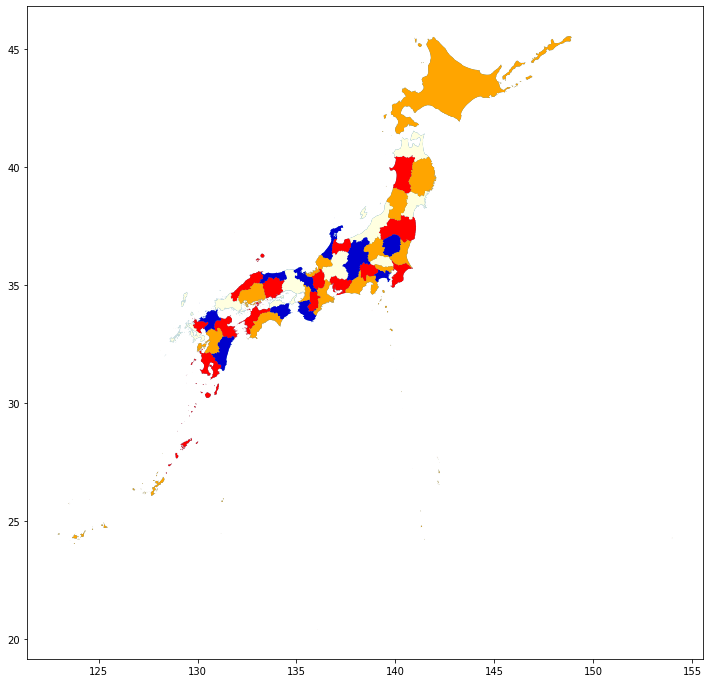

In [189]:
ax = df.plot(figsize=(15,12))
colors = ['red', 'lightyellow', 'mediumblue', 'orange']
assert len(colors) >= N_COLOR

gdf = gpd.GeoDataFrame(df)

for prefs, color in zip(ans2, colors):
    #print(color)
    #for p in prefs:
    #    print(p, int2pref[p])
    gdf[gdf['id'].isin(prefs)].plot(ax=ax, color=color)